# Accelerated Multiscale Pyramid Generation

This example demonstrates accelerated multiscale image pyramid generation for registration in ITK with VkFFT.

Pairwise image registration concerns iterative alignment of two N-dimensional images. When aligning large, detailed images it is often useful to initialize global alignment by blurring and registering images before refining local alignment on more detailed images. An image scale space can be constructed by iteratively applying Gaussian blurring of different strengths, ranging from very blurred (0th image) to very detailed (nth image).

ITK defines `itk.MultiScalePyramidImageFilter` which makes use of Gaussian blurring and subsequent resampling methods to construct and output an image scale space. Blurring is accomplished via convolution of an image with a Gaussian kernel. Spatial convolution with `itk.DiscreteGaussianImageFilter` runs quickly with very small kernels, but can be very slow for convolution of large images with large kernels. `itk.FFTDiscreteGaussianImageFilter`, by comparison, runs convolution in the frequency domain with a performance that is much less sensitive to kernel size, but is typically slower than spatial convolution for small kernels.

`itk.VkMultiScalePyramidImageFilter` balances these smoothing options by polling the kernel size for each level and selecting the appropriate smoothing filter. In this example we demonstrate multiscale pyramid generation and compare performance between the default ITK pyramid image filter and the accelerated ITK VkFFT pyramid image filter.

In [1]:
import sys
#!{sys.executable} -m pip install matplotlib itk itk-vkfft

In [2]:
import os
import time
import math

import itk
import numpy as np
import matplotlib.pyplot as plt

assert 'VkMultiResolutionPyramidImageFilter' in dir(itk)

In [3]:
itk.VkGlobalConfiguration.SetDeviceID(1)  # Select the appropriate OpenCL device

### Define Input

For demonstration purposes we generate a contrived large 3D input image. The image in question contains significant speckle noise and a large, uniform box. Slices along the 0th (i) image axis are visualized throughout the example.

Image size: itkSize3 ([500, 500, 500])


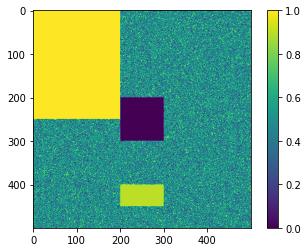

In [4]:
ImageDimension = 3
PixelType = itk.F
ImageType = itk.Image[PixelType, ImageDimension]

# Create a default 3D image with a large, continuous feature
def create_random_image(image_size:list=[500,500,500]) -> ImageType:
    arr = np.random.rand(*image_size).astype(np.float32)
    arr[0:80,0:250,0:200] = 1
    arr[0:10,200:300,200:300] = 0
    arr[0:400,400:450,200:300] = 0.9
    return itk.image_from_array(arr)

image = create_random_image()
print(f'Image size: {itk.size(image)}')
plt.imshow(image[0,:,:])
plt.colorbar()
plt.show()

### Prepare Acceleration Overrides

Factory mechanisms for VkFFT overrides are introduced ITK Python v5.3rc04. Three easy steps are required to accelerate pyramid generation:
1.  VkFFT filters are set as the default backend for ITK FFT computation. This is accomplished implicitly via itk module loading, no user steps are required.
2.  `itk.DiscreteGaussianImageFilter` instantiation is overloaded so that an `itk.FFTDiscreteGaussianImageFilter` instance will be returned via the ITK object factory. This effectively adjusts behavior such that any ITK filter internally using discrete gaussian blurring, such as `itk.MultiResolutionPyramidImageFilter`, will now use FFT convolution to perform that blurring.
3.  (Optional) The user selects the default accelerated device for VkFFT filters to use. This is mostly relevant on systems where more than one device is compatible with the accelerated backend, such as a laptop with OpenCL drivers for both CPU and notebook GPU. The user is responsible for selecting the correct device for their system. A tool such as `clinfo` may be used to query this information.

In [5]:
# Verify whether VkFFT is default backend
def is_acceleration_enabled():
    ComplexImageType = itk.Image[itk.complex[PixelType],ImageDimension]
    basefft_type = itk.ForwardFFTImageFilter[ImageType,ComplexImageType]

    # Check whether VkFFT is default FFT implementation (expected)
    fft_filter = basefft_type.New()
    if fft_filter.GetNameOfClass() != 'VkForwardFFTImageFilter':
        print(f'VkFFT was not found as the default FFT backend. Please verify itk>=5.3rc04 and itk-vkfft>=0.1.3.')
        return False
    
    return True

## Non-Accelerated Pyramid Generation

A six-level scale space is generated for the input image according to a default schedule.

In [6]:
def initialize_pyramid_filter(pyramid_filter_type, n_levels:int=4):
    pyramid_filter = pyramid_filter_type.New()
    pyramid_filter.SetInput(image)
    pyramid_filter.SetNumberOfWorkUnits(2)
    pyramid_filter.SetNumberOfLevels(n_levels)
    
    factors = itk.FixedArray[itk.UI,ImageDimension]()
    factors.SetElement(0,2 ** (n_levels - 1))
    factors.SetElement(1,2 ** (n_levels - 1))
    factors.SetElement(2,2 ** (n_levels - 3))
    pyramid_filter.SetStartingShrinkFactors(factors.GetDataPointer())
    
    return pyramid_filter
    
pyramid_filter_type = itk.MultiResolutionPyramidImageFilter[ImageType,ImageType]
n_levels = 6

default_pyramid_filter = initialize_pyramid_filter(pyramid_filter_type, n_levels)

In [7]:
sched = default_pyramid_filter.GetSchedule()
for dim in range(3):
    for level in range(n_levels):
        pass
        #        sched.SetElement(level,dim,int((dim+1) ** ((n_levels - 1 - level) / 3)))

In [8]:
def print_schedule(pyramid_filter:pyramid_filter_type):
    schedule = pyramid_filter.GetSchedule()
    print(f'Schedule size: {schedule.rows()} levels x {schedule.cols()} dimensions\n')

    print(f'\t\tk\tj\ti')
    for i in range(schedule.rows()):
        print(f'Level {str(i)}:\t' + '\t'.join([str(schedule.GetElement(i,j)) for j in range(schedule.cols())]))
        
print_schedule(default_pyramid_filter)

Schedule size: 6 levels x 3 dimensions

		k	j	i
Level 0:	32	32	8
Level 1:	16	16	4
Level 2:	8	8	2
Level 3:	4	4	1
Level 4:	2	2	1
Level 5:	1	1	1


In [9]:
# Profile pyramid generation
def generate_pyramid(pyramid_filter) -> float:
    starttime = time.time()
    print(f'Updating {type(pyramid_filter)}')
    pyramid_filter.Update()
    endtime = time.time()
    
    elapsed_time = endtime - starttime
    print(f'Generated pyramid in {elapsed_time:0.4f} s')
    return elapsed_time
    
baseline_elapsed_time = generate_pyramid(default_pyramid_filter)

Updating <class 'itk.itkMultiResolutionPyramidImageFilterPython.itkMultiResolutionPyramidImageFilterIF3IF3'>
Generated pyramid in 26.6420 s


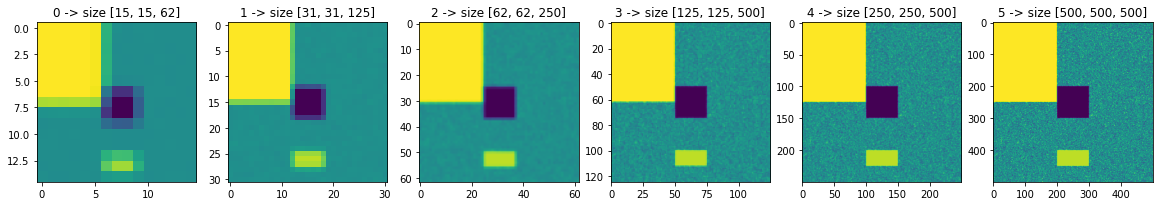

In [10]:
# Plot image output levels from least to most detailed.
def plot_output(pyramid_filter:pyramid_filter_type):
    n_levels = pyramid_filter.GetNumberOfLevels()
    fig, axs = plt.subplots(nrows=1, ncols=n_levels, figsize=(20,20))
    axs = np.expand_dims(axs,0)

    for row in range(1):
        for col in range(n_levels):
            output_image = pyramid_filter.GetOutput(row * n_levels + col)
            if(math.isnan(np.max(output_image))):
                print(f'Got nan at level {col}')
                
            axs[row,col].imshow(output_image[0,:,:])
            axs[row,col].set_title(f'{row * n_levels + col} -> size {list(itk.size(output_image))}')

    plt.show()
    
plot_output(default_pyramid_filter)

### GPU Accelerated Pyramid Generation

FFT convolution is enabled as the default blurring mechanism, subsequently leveraging VkFFT GPU acceleration. The same multiscale pyramid is generated from scratch.

In [11]:
def get_kernel_radius(variance, direction):
    oper = itk.GaussianOperator[itk.F,ImageDimension]()
    oper.SetDirection(direction)
    oper.SetMaximumError(0.1)
    oper.SetMaximumKernelWidth(32)
    oper.SetVariance(variance if type(variance) in [float, int] else variance[direction])
    oper.CreateDirectional()
    return oper.GetRadius(direction)

def make_variance_arr(factors):
    return [(0.5 * factors[dim]) ** 2 for dim in range(ImageDimension)]

def get_factors(sched, ilevel):
    return [sched.GetElement(ilevel,dim) for dim in range(ImageDimension)]

schedule = default_pyramid_filter.GetSchedule()
for level in range(n_levels):
    print(f'{level}: {[get_kernel_radius(make_variance_arr(get_factors(schedule, level)),dim) for dim in range(ImageDimension)]}')

0: [27, 27, 7]
1: [13, 13, 3]
2: [7, 7, 2]
3: [3, 3, 1]
4: [2, 2, 1]
5: [1, 1, 1]


In [12]:
vk_pyramid_filter_type = itk.VkMultiResolutionPyramidImageFilter[ImageType,ImageType]
accelerated_pyramid_filter = initialize_pyramid_filter(vk_pyramid_filter_type,n_levels)
accelerated_pyramid_filter.SetSchedule(sched)

print_schedule(accelerated_pyramid_filter)
#print(accelerated_pyramid_filter)

#assert is_acceleration_enabled()
accelerated_elapsed_time = generate_pyramid(accelerated_pyramid_filter)

Schedule size: 6 levels x 3 dimensions

		k	j	i
Level 0:	32	32	8
Level 1:	16	16	4
Level 2:	8	8	2
Level 3:	4	4	1
Level 4:	2	2	1
Level 5:	1	1	1
Updating <class 'itk.itkVkMultiResolutionPyramidImageFilterPython.itkVkMultiResolutionPyramidImageFilterIF3IF3'>
Generated pyramid in 17.9734 s


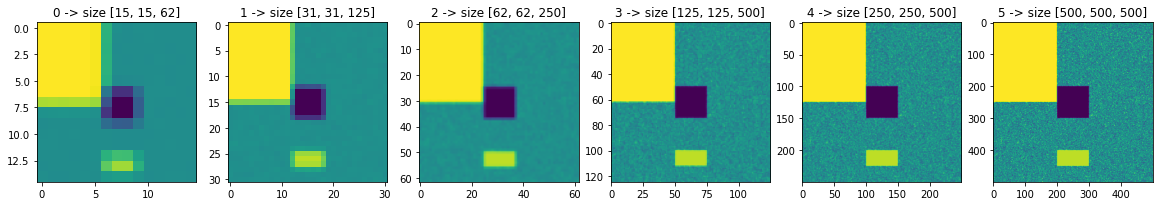

In [13]:
plot_output(accelerated_pyramid_filter)

## Compare CPU and GPU output

In [14]:
diff = baseline_elapsed_time - accelerated_elapsed_time
speedup = 1 - (accelerated_elapsed_time / baseline_elapsed_time)
print(f'VkFFT-accelerated pyramid generation gave speedup of {speedup:0.2%} ({diff:0.2f} s)')

VkFFT-accelerated pyramid generation gave speedup of 32.54% (8.67 s)
